### Hybrid Propulsion System Model

**Overview**
- Four propeller pods
- Two electric motors and one gas turbine per pod, connected mechanically via gearbox
- Gas turbine capable of charging the batteries via the electric motor


**Key Inputs**
- *Thrust required*: mission thrust required of each pod, according to flight profile (speed, altitude, flight path)
- *Pod Shaft Power Required* ($P_{\mathrm{pod}}$): computed via propeller momentum theory model.
- *GT Throttle Ratio* ($\lambda_{\mathrm{GT,pod}}$): ratio between the power supplied by the gas turbine and the power required by the pod. Can be set for each pod independently. 

$$
\lambda_{\mathrm{GT,pod}} = \frac{P_{\mathrm{gt}}}{P_{\mathrm{pod}}}
$$

Where:
- $\lambda_{\mathrm{GT,pod}} = 1$: Conventional mode (GT power only)
- $\lambda_{\mathrm{GT,pod}} < 1$: Hybrid mode (GT and E-motor power)
- $\lambda_{\mathrm{GT,pod}} > 1$: Generation mode (GT charges batteries via E-motor)

**Key Outputs**
$$
\begin{align*}
P_{\mathrm{gt}} &= \lambda_{\mathrm{GT,pod}} \times P_{\mathrm{pod}} \\
\lambda_{\mathrm{GT}} &= \frac{P_{\mathrm{gt}}}{P_{\mathrm{gt,max}}} \\
P_{\mathrm{e}} &= P_{\mathrm{pod}} - P_{\mathrm{gt}} \\
\lambda_{\mathrm{motor}} &= \frac{P_{\mathrm{e}}}{N_{\mathrm{motors}} \times P_{\mathrm{motor,max}}} \\
\gamma &= \frac{P_{\mathrm{e}}}{P_{\mathrm{pod}}}
\end{align*}
$$

**Where**
- $P_{\mathrm{gt}}$: Gas turbine mechanical power per pod
- $P_{\mathrm{e}}$: Total Electric motor mechanical power per pod
- $N_{\mathrm{motors}}$: Number of electric motors per pod
- $\lambda_{\mathrm{GT}}$: Gas turbine throttle (0 to 1)
- $\lambda_{\mathrm{motor}}$: Electric motor throttle (0 to 1)
- $\gamma$: Hybridization factor (-1 to 1)
  - $\gamma > 0$: Electric motors providing power
  - $\gamma < 0$: Electric motors receiving power (battery charging)
  - $\gamma = 0$: Pure gas turbine operation

In [7]:
# Import Packages
import openmdao.api as om
import numpy as np
import pdb 
import matplotlib.pyplot as plt
from computepropeller import ComputePropeller
from computeamos import ComputeAtmos
from grouphybridpod import GroupPods


In [8]:

""" 
Setup Model
"""

# Define number of analysis points
nn = 30  # Single point analysis


# Define Aircraft Parameters
mtom_lb = 85000 
mtom_kg = mtom_lb * 0.453592
g = 9.806
l_d = 17
num_pods = 4

# Build Climb Profile
len_climb = int(np.floor(nn/2-1))
x = np.arange(len_climb)

x0 = 0.5 # final climb angle gradient
x1 = 9 # initial climb angle gradient
k = 3 # decay rate 

r = x1 - x0
climb_ang_grad =  x0 + r * np.exp(-k * x / len_climb)
climb_ang_rad = np.arctan(climb_ang_grad/100)   

descent_ang_grad = -5
descent_ang_rad = np.arctan(descent_ang_grad/100)

gamma_climb = climb_ang_rad * np.ones(len_climb)
len_descent = len_climb
gamma_descent = descent_ang_rad * np.ones(len_descent)
gamma_cruise = 0 * np.ones(nn - len_climb - len_descent)
gamma_mission = np.concatenate([gamma_climb, gamma_cruise, gamma_descent])


# Build thrust profile
thrust_idle = 1000 * np.ones(nn)
thrust_calc = mtom_kg * g * (1/ l_d + np.sin(gamma_mission))
thrust_total = np.where(thrust_calc > thrust_idle, thrust_calc, thrust_idle)
thrust_pod = thrust_total / num_pods


# Build GT Throttle ratio profile
x0 = 0.6 # minimum throttle ratio
x1 = 1 # maximum throttle ratio

r = x1 - x0 # range of throttle ratio
y = x0 + r * (np.log(np.arange(int(np.floor(nn/2-1))) + 1) / np.log(int(np.floor(nn/2-1))))

gt_throttle_ratio_clb = y # throttle ratio for climb
gt_throttle_ratio_des =  1.4 * np.ones(int(np.floor(nn/2-1)))
gt_throttle_ratio_cru =  np.ones(nn - len(gt_throttle_ratio_clb) - len(gt_throttle_ratio_des))
gt_throttle_ratio_mission = np.concatenate([gt_throttle_ratio_clb, gt_throttle_ratio_cru, gt_throttle_ratio_des])



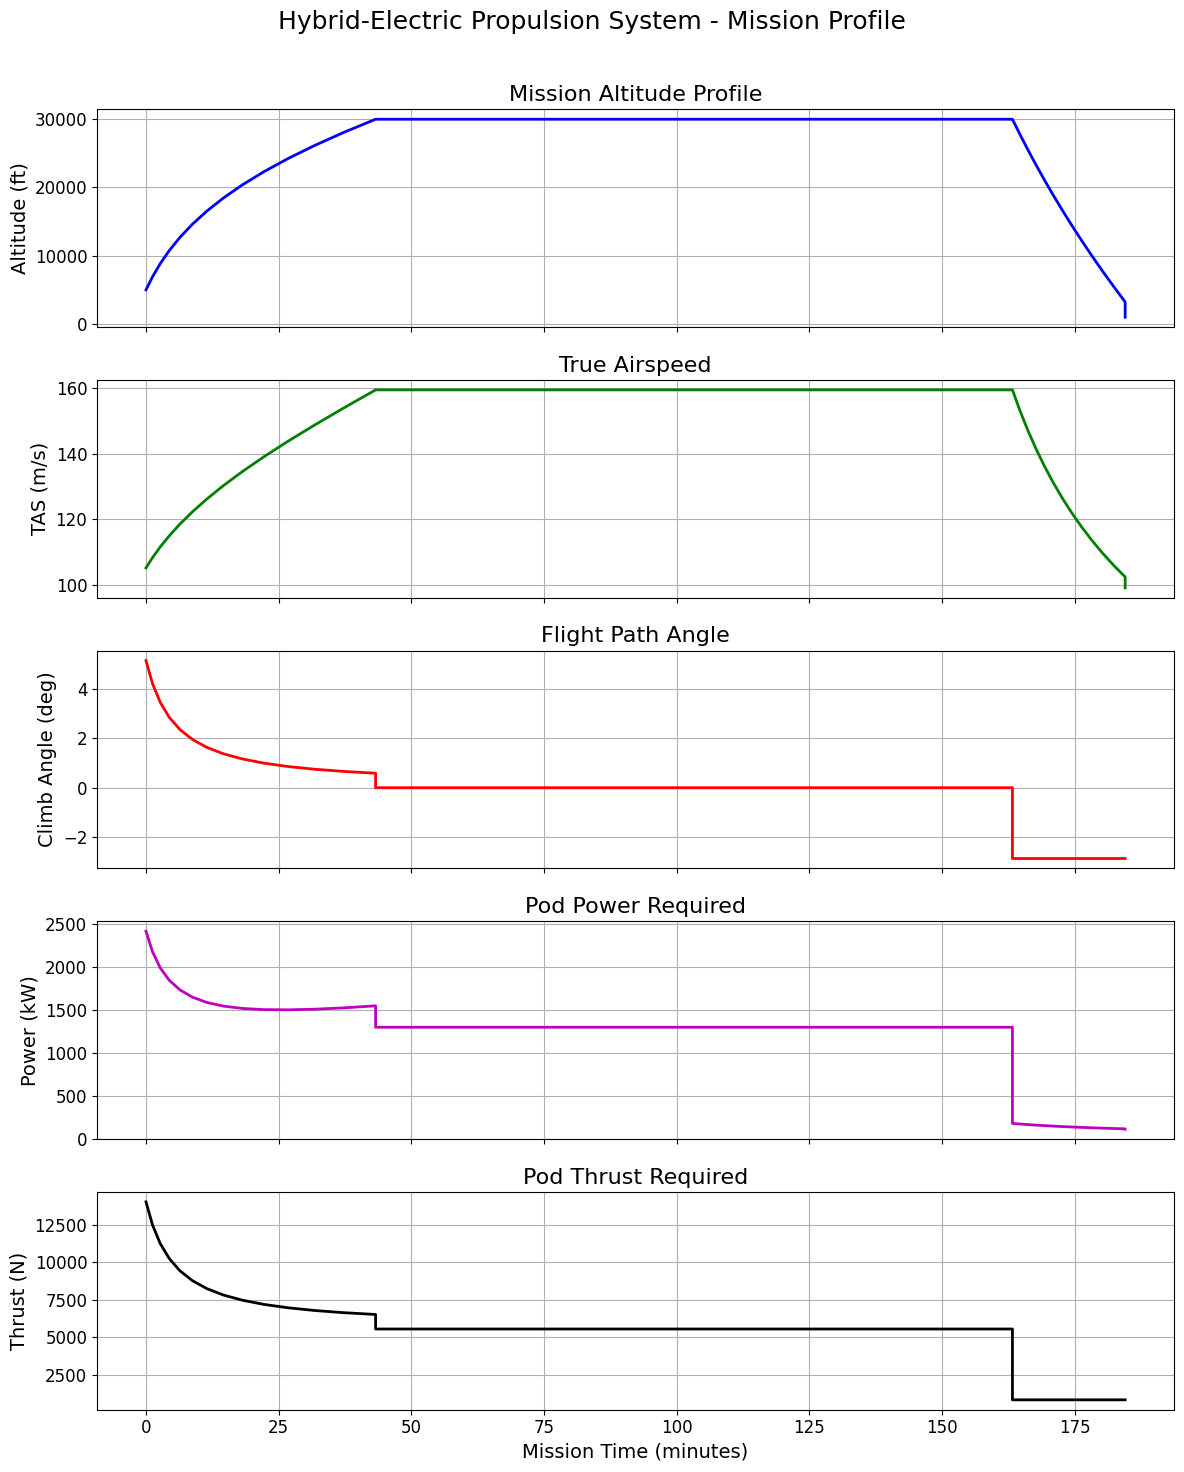

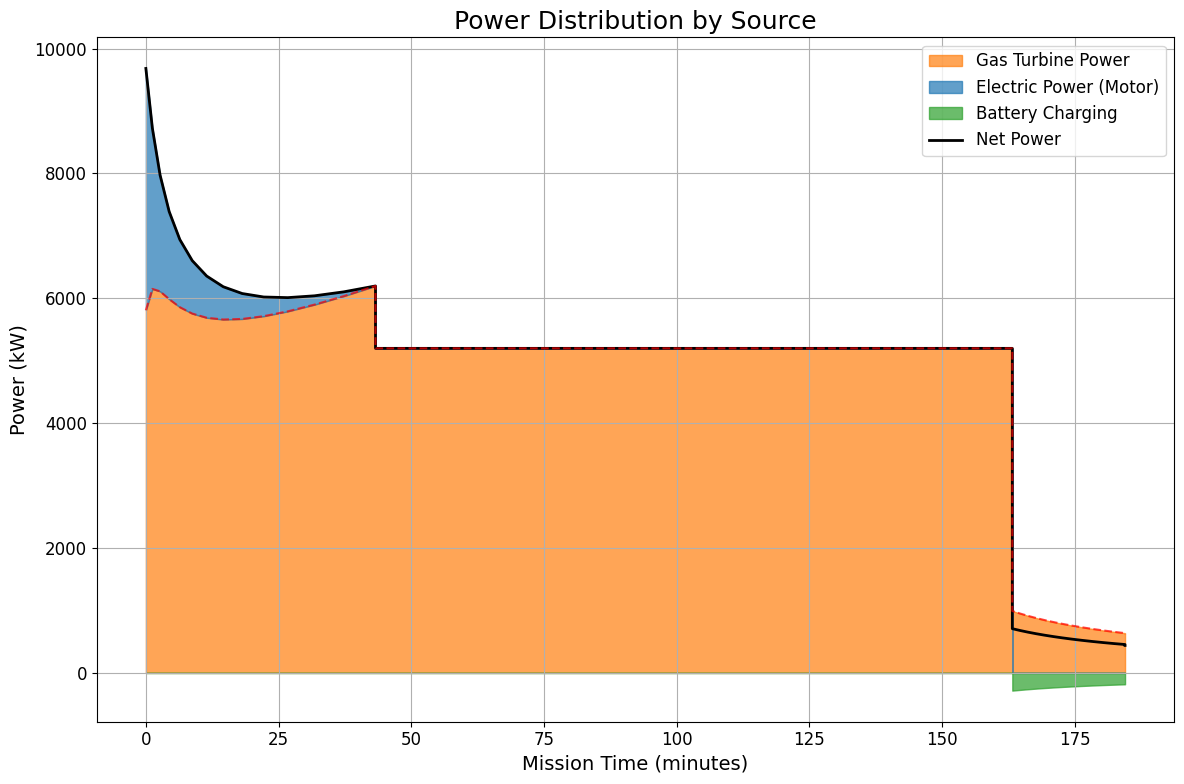

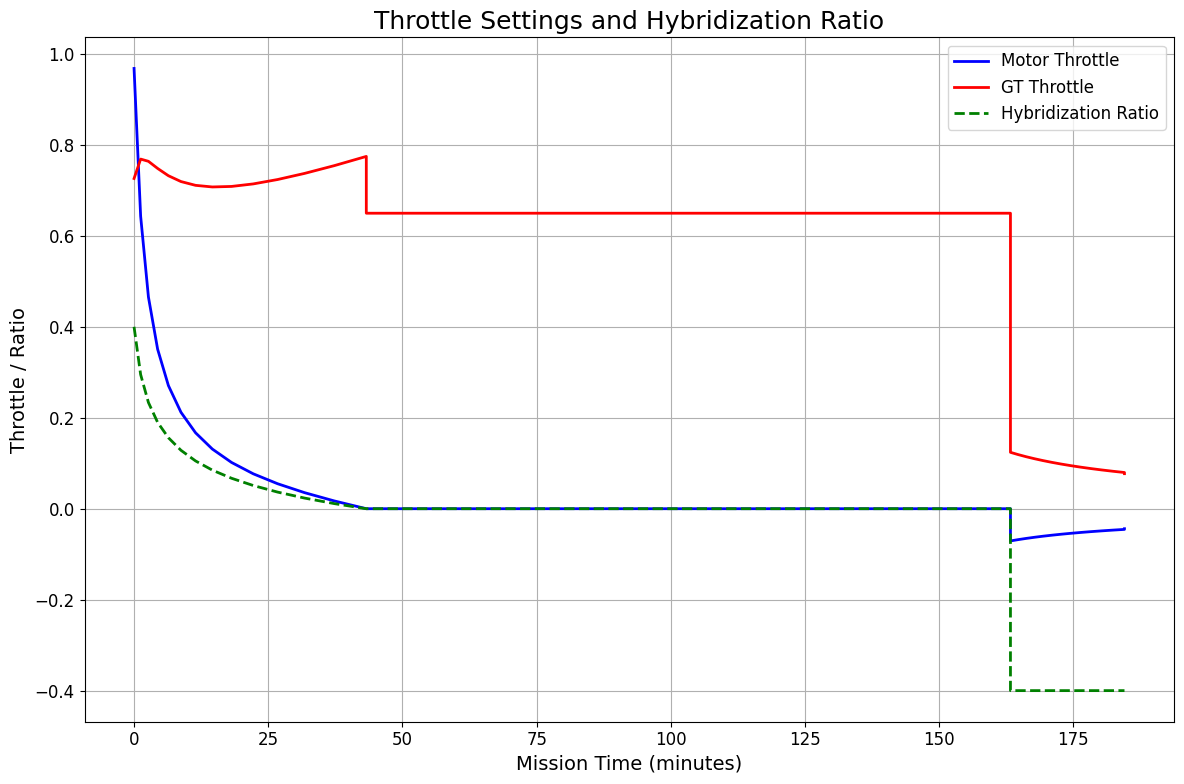

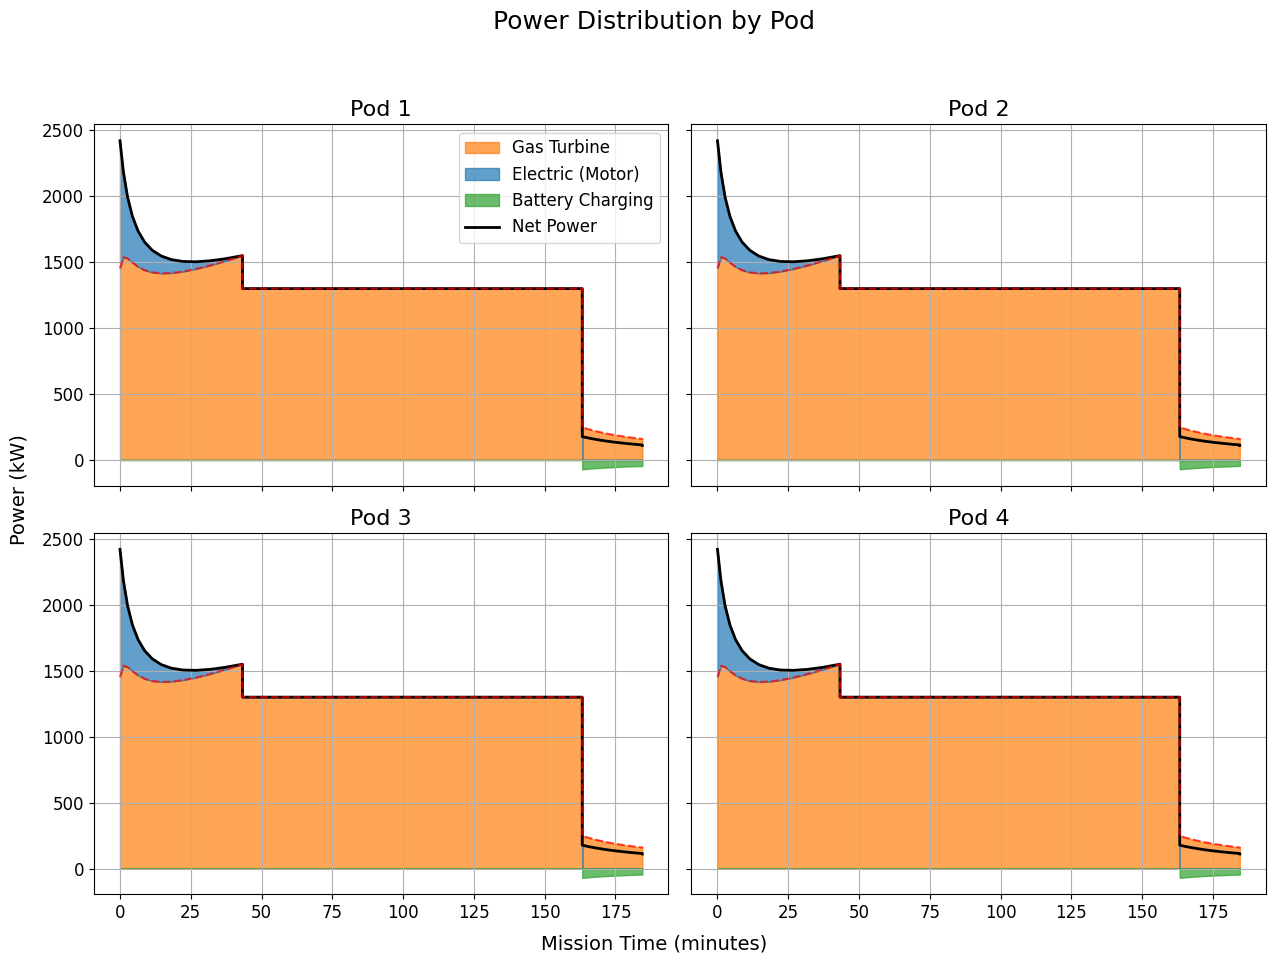

In [9]:

# Create the OpenMDAO problem
prob = om.Problem()
ivc = om.IndepVarComp()

# Speed 
ivc.add_output('eas', val=190 * np.ones(nn), units='kn')

# GT Throttle Ratio
ivc.add_output('gt_throttle_ratio_mission', val=gt_throttle_ratio_mission)

# Define pod paaramters
pop_diam_m = 4.2
prop_hub_m = 0.75
eta_prop  = 0.8
max_motor_pow_W = 5e5
max_gt_pow_W = 2e6

for i in range(num_pods):
    # Propeller parameters
    ivc.add_output(f'pod{i+1}|blade_diam', pop_diam_m * np.ones(nn), units='m')
    ivc.add_output(f'pod{i+1}|hub_diam', prop_hub_m * np.ones(nn), units='m')
    ivc.add_output(f'pod{i+1}|thrust_req', thrust_pod * np.ones(nn), units='N')
    ivc.add_output(f'pod{i+1}|eta_prop', eta_prop * np.ones(nn), units=None)

    # Pod power parameters
    ivc.add_output(f'pod{i+1}|gt_throttle_ratio', val=gt_throttle_ratio_mission)
    ivc.add_output(f'pod{i+1}|max_motor_pow', val=max_motor_pow_W * np.ones(nn), units='W')
    ivc.add_output(f'pod{i+1}|max_gt_pow', val=max_gt_pow_W * np.ones(nn), units='W')

# Build flight profile 
alt_climb = np.linspace(5000, 30000, int(np.floor(nn/2-1)))
alt_descent = np.linspace(30000, 1000, int(np.floor(nn/2-1)))
alt_cruise = np.ones(nn-len(alt_climb)-len(alt_descent)) * 30000

len_crz = len(alt_cruise)
len_des = len(alt_descent)
len_clb = len(alt_climb)

alt = np.concatenate([alt_climb, alt_cruise, alt_descent])

ivc.add_output('alt', val=alt, units='ft')

# Connect to group
prob.model.add_subsystem('inputs', ivc, promotes_outputs=['*'])
prob.model.add_subsystem('hybrid_pod', 
                        GroupPods(nn=nn),
                        promotes_inputs=['*'], promotes_outputs=['*'])

# Setup the problem
prob.setup()

#om.n2(prob)
#prob.check_partials(compact_print=True)

# Run the analysis
prob.run_model()



# Compute Mission Time
t0 = 0
dz_clb_m = np.diff(prob.get_val('alt')[0:len_clb]) * 0.3048
dz_clb_m = np.concatenate([[0], dz_clb_m])

dt_clb_s = dz_clb_m / (prob.get_val('tas')[0:len_clb] * np.sin(gamma_climb))
t_climb_s = t0 + np.cumsum(dt_clb_s)
t_crz_s = np.linspace(t_climb_s[-1], t_climb_s[-1] + 2 * 60 * 60, len_crz)

dz_des_m = np.diff(prob.get_val('alt')[len_clb + len_crz-1:-1]) * 0.3048
dz_des_m = np.concatenate([ dz_des_m, [0]])

dt_des_s = dz_des_m / (prob.get_val('tas')[len_clb + len_crz-1:-1] * np.sin(gamma_descent))
t_descent_s = t_crz_s[-1] + np.cumsum(dt_des_s)

t_mission_s = np.concatenate([t_climb_s, t_crz_s, t_descent_s])
t_mission_min = t_mission_s / 60

# Plot Data

# Create mission points array for x-axis
mission_points = np.arange(nn)

# Extract data for plotting
altitude = prob.get_val('alt')
tas = prob.get_val('tas')
thrust = prob.get_val('pod1|thrust_req')
pod_power = prob.get_val('pod1|pow_req') / 1000  # Convert to kW

# Get power data for all pods
gt_power = np.zeros((num_pods, nn))
e_power = np.zeros((num_pods, nn))
motor_throttle = np.zeros((num_pods, nn))
gt_throttle = np.zeros((num_pods, nn))
hybrid_ratio = np.zeros((num_pods, nn))

for i in range(1, num_pods+1):
    gt_power[i-1, :] = prob.get_val(f'pod{i}|gt_pow') / 1000  # Convert to kW
    e_power[i-1, :] = prob.get_val(f'pod{i}|e_pow') / 1000    # Convert to kW
    motor_throttle[i-1, :] = prob.get_val(f'pod{i}|motor_throttle')
    gt_throttle[i-1, :] = prob.get_val(f'pod{i}|gt_throttle')
    hybrid_ratio[i-1, :] = prob.get_val(f'pod{i}|hy_ratio')

# Calculate total GT and electric power across all pods
total_gt_power = np.sum(gt_power, axis=0)
total_e_power = np.sum(e_power, axis=0)

# Set up for nicer plots
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = [12, 10]

# Graph 1: Multiple subplots
fig1, axs = plt.subplots(5, 1, figsize=(12, 15), sharex=True)
fig1.suptitle('Hybrid-Electric Propulsion System - Mission Profile', fontsize=18)

# Altitude subplot
axs[0].plot(t_mission_min, altitude, 'b-', linewidth=2)
axs[0].set_ylabel('Altitude (ft)')
axs[0].set_title('Mission Altitude Profile')
axs[0].grid(True)

# TAS subplot
axs[1].plot(t_mission_min, tas, 'g-', linewidth=2)
axs[1].set_ylabel('TAS (m/s)')
axs[1].set_title('True Airspeed')
axs[1].grid(True)

# Climb angle subplot
axs[2].plot(t_mission_min, np.degrees(gamma_mission), 'r-', linewidth=2)
axs[2].set_ylabel('Climb Angle (deg)')
axs[2].set_title('Flight Path Angle')
axs[2].grid(True)

# Pod power subplot
axs[3].plot(t_mission_min, pod_power, 'm-', linewidth=2)
axs[3].set_ylabel('Power (kW)')
axs[3].set_title('Pod Power Required')
axs[3].grid(True)

# Thrust subplot
axs[4].plot(t_mission_min, thrust, 'k-', linewidth=2)
axs[4].set_ylabel('Thrust (N)')
axs[4].set_xlabel('Mission Time (minutes)')
axs[4].set_title('Pod Thrust Required')
axs[4].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])

# Graph 2: Stacked area chart for power distribution
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.set_title('Power Distribution by Source', fontsize=18)

# Create stacked area chart - properly handling negative e_power
ax2.fill_between(t_mission_min, 0, total_gt_power, color='#FF7F0E', alpha=0.7, label='Gas Turbine Power')

# Separate positive and negative electric power
pos_mask = total_e_power >= 0
neg_mask = total_e_power < 0

# For positive electric power - stack above GT power
if np.any(pos_mask):
    ax2.fill_between(t_mission_min, 
                    np.where(pos_mask, total_gt_power, 0), 
                    np.where(pos_mask, total_gt_power + total_e_power, 0), 
                    color='#1F77B4', alpha=0.7, label='Electric Power (Motor)')

# For negative electric power - show below zero as battery charging
if np.any(neg_mask):
    ax2.fill_between(t_mission_min, 
                    np.where(neg_mask, total_e_power, 0), 
                    0, 
                    color='#2CA02C', alpha=0.7, label='Battery Charging')

# Add the total power line
ax2.plot(t_mission_min, total_gt_power + total_e_power, 'k-', linewidth=2, label='Net Power')

# Also add the GT power line for clarity
ax2.plot(t_mission_min, total_gt_power, 'r--', linewidth=1.5, alpha=0.7)

ax2.set_xlabel('Mission Time (minutes)')
ax2.set_ylabel('Power (kW)')
ax2.grid(True)
ax2.legend(loc='upper right')

plt.tight_layout()

# Graph 3: Motor throttle, GT throttle, and hybridization ratio
fig3, ax3 = plt.subplots(figsize=(12, 8))
ax3.set_title('Throttle Settings and Hybridization Ratio', fontsize=18)

# We'll plot for the first pod (assume all pods are the same)
pod_idx = 0

ax3.plot(t_mission_min, motor_throttle[pod_idx], 'b-', linewidth=2, label='Motor Throttle')
ax3.plot(t_mission_min, gt_throttle[pod_idx], 'r-', linewidth=2, label='GT Throttle')
ax3.plot(t_mission_min, hybrid_ratio[pod_idx], 'g--', linewidth=2, label='Hybridization Ratio')

ax3.set_xlabel('Mission Time (minutes)')
ax3.set_ylabel('Throttle / Ratio')
ax3.grid(True)
ax3.legend(loc='upper right')

plt.tight_layout()

# Graph 4: Individual pod power distribution
fig4, axs4 = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig4.suptitle('Power Distribution by Pod', fontsize=18)

# Flatten the 2x2 array for easier indexing
axs4_flat = axs4.flatten()

for i in range(num_pods):
    ax = axs4_flat[i]
    
    # Get this pod's power data
    pod_gt_power = gt_power[i, :]
    pod_e_power = e_power[i, :]
    
    # Create stacked area chart for this pod - properly handling negative e_power
    ax.fill_between(t_mission_min, 0, pod_gt_power, color='#FF7F0E', alpha=0.7, label='Gas Turbine')
    
    # Separate positive and negative electric power
    pos_mask = pod_e_power >= 0
    neg_mask = pod_e_power < 0
    
    # For positive electric power - stack above GT power
    if np.any(pos_mask):
        ax.fill_between(t_mission_min, 
                        np.where(pos_mask, pod_gt_power, 0), 
                        np.where(pos_mask, pod_gt_power + pod_e_power, 0), 
                        color='#1F77B4', alpha=0.7, label='Electric (Motor)')
    
    # For negative electric power - show below zero as battery charging
    if np.any(neg_mask):
        ax.fill_between(t_mission_min, 
                        np.where(neg_mask, pod_e_power, 0), 
                        0, 
                        color='#2CA02C', alpha=0.7, label='Battery Charging')
    
    # Add the total power line
    ax.plot(t_mission_min, pod_gt_power + pod_e_power, 'k-', linewidth=2, label='Net Power')
    
    # Also add the GT power line for clarity
    ax.plot(t_mission_min, pod_gt_power, 'r--', linewidth=1.5, alpha=0.7)
    
    ax.set_title(f'Pod {i+1}')
    ax.grid(True)
    
    # Only add legends to the first plot to avoid clutter
    if i == 0:
        ax.legend(loc='upper right')

# Add common x and y labels
fig4.text(0.5, 0.04, 'Mission Time (minutes)', ha='center', fontsize=14)
fig4.text(0.04, 0.5, 'Power (kW)', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# Show all plots
plt.show()

